In [121]:
# If you dont have the onnxruntime 
#!pip install onnxruntime

In [1]:
import onnxruntime as rt
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

In [2]:
# load session 
sess = rt.InferenceSession("dishan_segnet_v2.onnx")
# same as pilotNet


In [3]:
# load image
# Im only loading a one picture from the folder. 
# The reason that I used io collection is I want to create a same environment for inputs
# in both matlab when we trained the  data. 

img = io.ImageCollection("images/7jpg/*", conserve_memory=True)

np_img = np.array(img)

# optional
size =  np_img.shape[1]

print("np_img.shape",np_img.shape)
size

np_img.shape (1, 256, 256, 3)


256

Reshaping the picture according to the input dimentions of the model

In [4]:
# The model creaeted uses the shape of 1 x 256 x 256 x 3
# Had to reshape it becasue the model wont accept any other inputs
np_reshape = np.reshape(img,(1, 3, size,size))
np_reshape.shape

(1, 3, 256, 256)

In [5]:
# Lets look at the input output layers of the onnx network

input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[-1].name
print("input layer : ",input_name)
print("output layer :",output_name)

input layer :  imageinput
output layer : softmax_Transpose2


# Run model

In [6]:
output_name="softmax_Transpose2"

#convert to float 
floatAstype = np.float32(np_reshape)

print(output_name)
print(floatAstype.shape)
print(type(floatAstype))

# Run the model
pred_onx = sess.run("",{input_name:floatAstype})
print(np.array(pred_onx).shape)

softmax_Transpose2
(1, 3, 256, 256)
<class 'numpy.ndarray'>
(1, 1, 4, 256, 256)


<h5>Lets look at the output.</h5>


Glimpse of image we started with

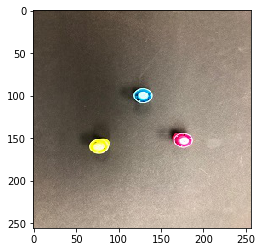

In [184]:
# Original image
originalImage = np.reshape(img,(256,256,3))
plt.imshow(originalImage)

<h1>4. Classification Confidence values</h1>

Identifying the confindce score in classification 

First lets try to create the confidention score for each weight.

<h1> Lets look at some weight from matlab </h1>


Make sense of that weights destribution and or something

'Blue' = 'green canopy cover'

'Pink' =  'soil surface'

'Yellow' =  'stubble from previous crops'

'Bed' = 'None 



In [7]:
Blue = 1.268578352180937 * 100
Pink = 1.146015761821366  * 100
Yellow =  1.125000000000000  * 100
Bed = 1.026164750897772
print(Blue)
print(Pink)
print(Yellow)
print(Bed)

126.85783521809371
114.6015761821366
112.5
1.026164750897772


In [8]:
sum_all_weights = Blue + Pink + Yellow + Bed
print(sum_all_weights)

354.98557615112804


In [9]:
Blue_per = Blue / sum_all_weights
Pink_per = Pink / sum_all_weights
Yellow_per = Yellow / sum_all_weights
Bed_per = Bed / sum_all_weights
print(Blue_per)
print(Pink_per)
print(Yellow_per)
print(Bed_per)

0.3573605344575649
0.3228344583030248
0.31691428485563417
0.0028907223837762435


# Something to look at

In [10]:
print(np.array(pred_onx).shape)
print(pred_onx[0][0][0][0][0])
print(pred_onx[0][0][1][0][0])
print(pred_onx[0][0][2][0][0])
print(pred_onx[0][0][3][0][0])

sum_of_pixel = pred_onx[0][0][0][0][0] + pred_onx[0][0][1][0][0] + pred_onx[0][0][2][0][0] + pred_onx[0][0][3][0][0]
sum_of_pixel

(1, 1, 4, 256, 256)
0.29843783
0.25202093
0.29099035
0.15855077


0.9999999

In [12]:
print(np.array(pred_onx).shape)
print(pred_onx[0][0][0][0][1])
print(pred_onx[0][0][1][0][1])
print(pred_onx[0][0][2][0][1])
print(pred_onx[0][0][3][0][1])

sum_of_pixel = pred_onx[0][0][0][0][1] + pred_onx[0][0][1][0][1] + pred_onx[0][0][2][0][1] + pred_onx[0][0][3][0][1]
sum_of_pixel

(1, 1, 4, 256, 256)
0.31822252
0.33571064
0.20385598
0.14221087


1.0

<h5>It's softmax</h5>

In [13]:
# size is 256
width = size
height = size


# Creating the array 

image_construced = np.empty(shape=[width, height])
max_probability_holder = np.empty(shape=[width, height])
label_holder = np.empty(shape=[width, height])

for x in range(width):
    for y in range(height):
        index = 0
        max_prediction = 0
        for i in range(0,4):
            pred = pred_onx[0][0][i][x][y]
            if pred > max_prediction:
                index = i
                max_prediction = pred
        
        
        max_probability_holder[x][y] = max_prediction
        
        # ignore the rest of the max_prediction prediction portion
        
        # End of for loop for each row of 4 softmax probabilities
        # Then we check with weights to see which catogory its in 
        
        # Blue_per   =   0.3573605344575649
        # Pink_per   =   0.3228344583030248
        # Yellow_per =   0.31691428485563417
        # Bed_per    =  0.0028907223837762435
       
        if max_prediction > 0.3573605344575649:
            image_construced[x][y] = 1
            label_holder = "canopy"
        elif max_prediction >  0.3228344583030248:
            image_construced[x][y] = 2
            label_holder = "soil"
        elif max_prediction >  0.31691428485563417:
            image_construced[x][y] = 3
            label_holder = "stubble"
        else:
            image_construced[x][y] = 4
            label_holder = "None" 
            


In [14]:
print(max_probability_holder[0][0])
print(max_probability_holder[0][1])
print(max_probability_holder[0][2])

0.29843783378601074
0.33571064472198486
0.4203324019908905


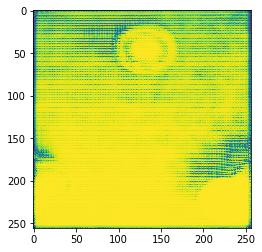

In [15]:
plt.imshow(max_probability_holder)

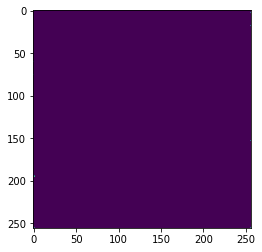

In [16]:
# still not sure about the weights
plt.imshow(image_construced)

In [32]:
# plt.imshow(label_holder)